# MNIST Variational Autoencoder

This notebook demonstrates the training of a variational autoencoder (VAE) on the MNIST dataset.  The decoder portion of the VAE is then used to generate arbitrary, new MNIST-like digits.

Note that we didn't reinvent this wheel - the code comes from [this excellent tutorial](https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f).

In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torch.optim as optim
import os

In [2]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

data = MNIST('./mnist_data', transform=transform, download=True)

In [3]:
loader = DataLoader(dataset=data, batch_size=100, shuffle=True, num_workers=20)

## The network

The cells above just set up our dataset and dataloader.

Below is the definition of our VAE.  Note that in the encoder, it decreases from 784 dimensions, to 400, to 200, and ultimately to 2, which are interpreted as a mean and variance of a distribution. To decode, we create a random point in 2-dimensional space, where each dimension is a number pulled from a normal distribution centered at that mean and with that variance.  That 200-dimensional point is then enlarged to a 400-dimensional point, and finally back to a 784-dimensional output.

Our loss function then has two components:
- The distance between the output image to the input image, and
- The distance between the mean and standard deviation and mean 0 and standard deviation 1.

The first component ensures the correct reproduction of the image.  The second ensures that the latent values going into the decoder are in a predictable region.

In [4]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to('cuda')      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

In [5]:
model = VAE().to('cuda')
optimizer = optim.Adam(model.parameters(), lr=1e-3)

The loss function is defined below.  `reproduction_loss` is the distance between the output and input images, and `KLD` is the [Kullback-Liebler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence), which measures the distance between the mean and variance and mean 0 and variance 1.

In [6]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [7]:
def train(model, optimizer, epochs, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(loader):
            x = x.view(100, x_dim).to('cuda')

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*100))
    return overall_loss

filename='mnist_autoencoder.pt'
if os.path.isfile(filename):
    model.load_state_dict(torch.load(filename))
    model=model.to('cuda')
else:
    train(model, optimizer, epochs=50)
    torch.save(model.state_dict(), filename)

OK, it's trained.  Now let's throw away the encoder, and play around with the decoder alone.  We know that the latent representations of MNIST numbers will have a small mean and a variance close to 1 (log_var close to 0).  So let's plug in some different values for MEAN and LOG_VAR which are close to that, and see what comes out of the decoder!

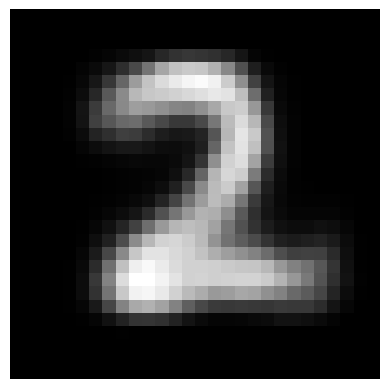

In [8]:
MEAN=.2
LOG_VAR=0

z_sample = torch.tensor([[MEAN,LOG_VAR]],dtype=torch.float32).to('cuda')
x_decoded = model.decode(z_sample)
digit = x_decoded.detach().cpu().reshape(28,28)
plt.imshow(digit, cmap='gray')
plt.axis('off')
plt.show()

That's pretty wild.  Let's try doing the same thing, but for many values of MEAN and LOG_VAR, and see how they relate.

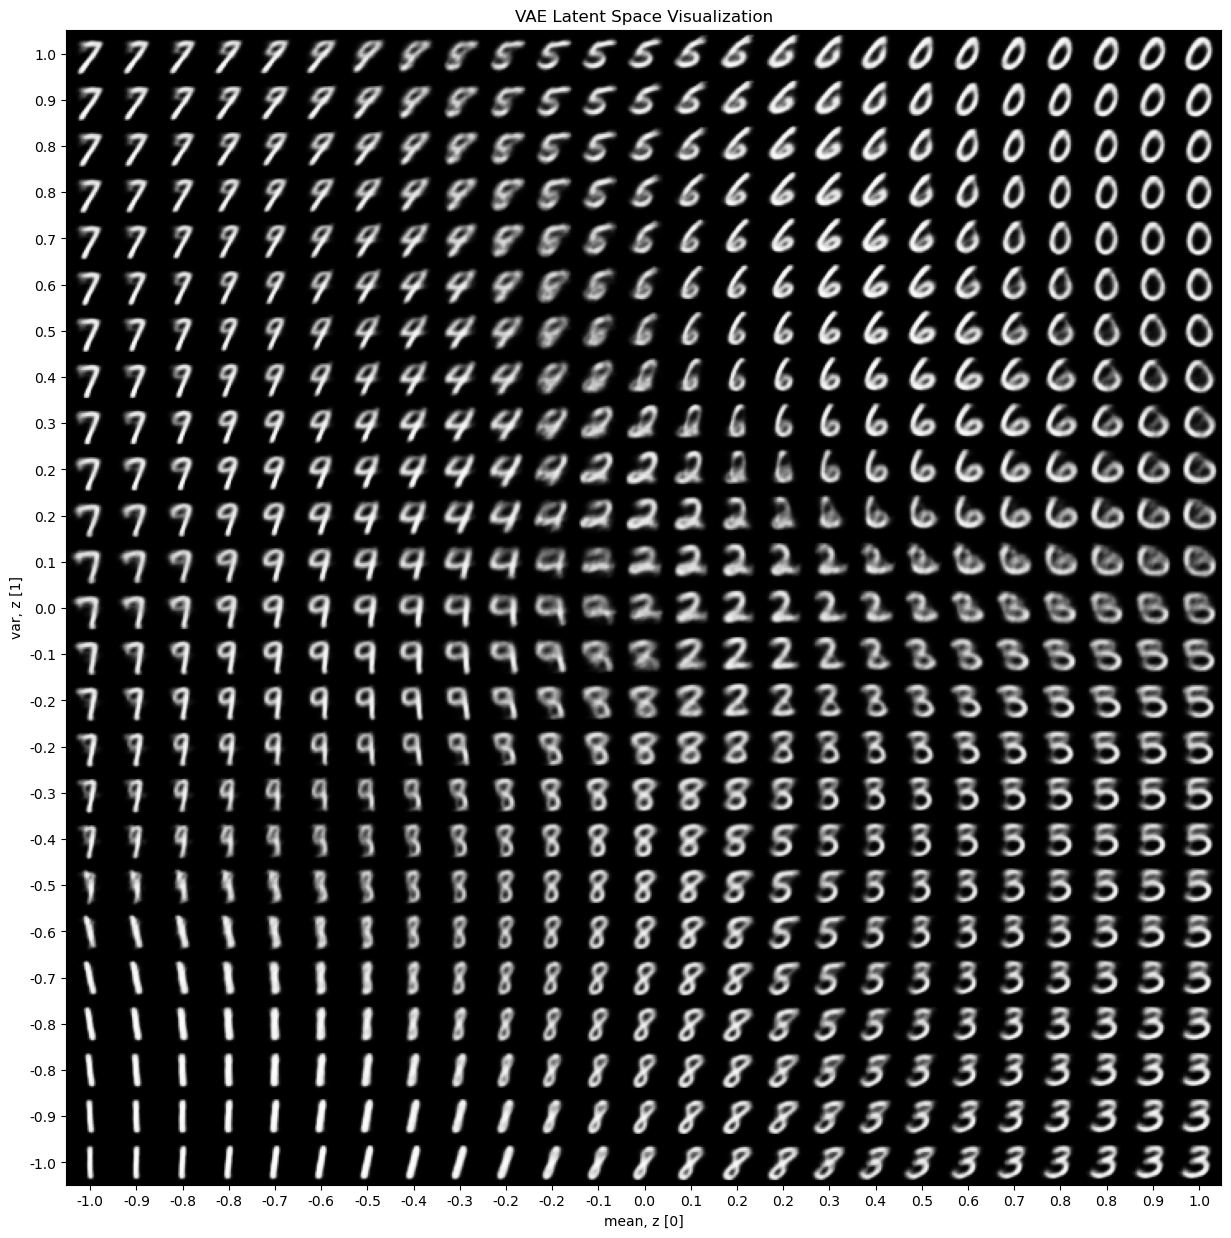

In [9]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to('cuda')
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model)